# **NetSIS & NetSEIRS: Custom Graph-Based Compartmental Models in PyTorch**

## Summary

This notebook presents the development and simulation of **NetSIS** and **NetSEIRS**, two network-based epidemiological models built from scratch using **PyTorch** and integrated with the **EpiLearn** framework (https://github.com/Emory-Melody/EpiLearn). These models simulate infectious disease dynamics over complex network structures, providing a flexible platform for testing intervention strategies and studying epidemic behavior in graph-based populations.

## Overview

We implemented:
- **NetSIS**: A susceptible–infected–susceptible model for simulating diseases without lasting immunity.
- **NetSEIRS**: A susceptible–exposed–infected–recovered–susceptible model for diseases with incubation periods, recovery, and immunity loss.

Both models:
- Extend `EpiLearn`'s `BaseModel` to leverage existing training/evaluation utilities.
- Use **trainable epidemiological parameters** (`β`, `γ`, `σ`, `ω`) for flexible calibration.
- Operate directly on **graph-structured data** via adjacency matrices, enabling realistic contact network simulations.

## Why it Matters
Traditional compartmental models assume a fully mixed population. Our approach
models realistic contact structures, enabling better prediction and analysis
of disease dynamics in social, biological, or transportation networks.

## Technical Highlights

- **Custom graph utilities**:
  - Conversion from NetworkX graphs to PyTorch adjacency matrices (directed & undirected support).
  - Directed graph visualization beyond EpiLearn's native undirected plotting.
- **Time-series transformation functions** for SIS and SEIRS predictions, allowing seamless visualization and analysis of compartmental state progression.
- **Scalable to large networks**: Tested on the Karate Club network and subsets of the Facebook social network graph.
- **Parameterizable simulations**: Horizon length, infection/recovery/incubation/immunity loss rates all adjustable for scenario testing.

This work combines **graph theory**, **compartmental epidemiology**, and **deep learning infrastructure** into a single, extensible modeling framework. It demonstrates:
- The integration of **PyTorch Geometric concepts** into traditional epidemiological modeling.
- The flexibility to adapt models for both small-scale and large-scale social networks.
- Readiness for extension into **data-driven epidemic forecasting** when real-world datasets become available.

## Tech Stack

- **Languages & Libraries**: Python, PyTorch, EpiLearn, NetworkX, NumPy, Matplotlib
- **Graph Handling**: NetworkX for structure creation/manipulation, custom adjacency matrix conversion
- **Visualization**: Matplotlib for time-series and network visualization
- **Simulation**: Custom NetSIS and NetSEIRS implementations following peer-reviewed epidemiological models

---
**Authors:**  
[Andrew Polyak](https://www.linkedin.com/in/andrewpolyak/)  
[Derek Regier](https://www.linkedin.com/in/derek-regier-4a9255336/)  

**Created:** May 2025

In [1]:
!pip install epilearn
!pip install torch_geometric
!pip install torch_scatter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.1/178.1 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
Reason for being yanked: The Windows wheels, under some conditions, caused segfaults in unrelated user code.  Due to this we deleted the Windows wheels to prevent these segfaults, however this caused greater disruption as pip then began to try (and fail) to build 3.9.1 from the sdist on Windows which impacted far more users.  Yanking the whole release is the only tool available to eliminate these failures without changes to on the user side.  The sdist, OSX wheel, and manylinux wheels are all functional and there are no critical bugs in the release.   Downstream packagers should not yank t

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch_scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=547368 sha256=acd299951f5ee1449149887a43fedf74f64c06061a5458073828914c66bbe1e7
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
Successfully built torch_scatter


In [1]:
import epilearn
from epilearn.data import UniversalDataset
from epilearn.utils import transforms
from epilearn.tasks import Forecast
from epilearn.utils import utils, simulation
from epilearn import visualize
import torch
import torch.nn as nn
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Utility Functions

## Convert NetworkX `graph` Object to Adjacency Matrix

Since we are dealing with network data (i.e., a set of nodes & connecting edges), we can leverage the `graph_to_adj_matrix` function to return the adjacency matrix of the graph.

The `graph_to_adj_matrix` function recieves a `networkx` graph object, extracts its attributes (such as `number_of_nodes` and a flat list of its edges), then maps each node to its respective connecting index, converts the edge list to a tensor, then fills in an adjacency matrix of shape `num_nodes * num_nodes` with the edge list data.

In [2]:
def graph_to_adj_matrix(G, directed=False):
    """
    Converts a NetworkX graph into an adjacency matrix.

    Args:
    - G (networkx.Graph): A NetworkX graph object.
    - directed (bool): Whether the graph is directed or undirected.

    Returns:
    - adj (torch.Tensor): The adjacency matrix as a PyTorch tensor.
    """
    # Get number of nodes and edges from the graph
    num_nodes = G.number_of_nodes()  # Ensure this is an integer (already correct)
    edges = list(G.edges())

    # Map node labels to indices
    node_to_index = {node: idx for idx, node in enumerate(G.nodes())}

    # Create the edge index tensor
    edge_indexes = [(node_to_index[node1], node_to_index[node2]) for node1, node2 in edges]
    edge_index_tensor = torch.tensor(edge_indexes, dtype=torch.long).t().contiguous()

    # Create the adjacency matrix, initialized to zeros
    adj = torch.zeros(num_nodes, num_nodes, dtype=torch.float)

    # Populate the adjacency matrix
    adj[edge_index_tensor[0], edge_index_tensor[1]] = 1

    # For undirected graphs, also set the reverse direction
    if not directed:
        adj[edge_index_tensor[1], edge_index_tensor[0]] = 1

    return adj

## Convert Model Predictions to Time-Series Array

We implement functions to convert model predictions for SIS and SEIRS into time-series arrays that can be plugged into the `epilearn.visualize.plot_series()` function.

In [3]:
def SIS_preds_to_time_series(preds):
    """
    Converts a model prediction of shape (time_steps, num_nodes, num_features)
    where num_features is [Susceptible, Infected] into a NumPy array representing
    time-series data about the fractional sum of each feature at each time step.
    """

    # Convert preds (torch tensor) to numpy object
    preds_np = preds.detach().numpy()

    # Get the sum of S and / or I for each time step
    total_S = preds_np[:, :, 0].sum(axis=1)
    total_I = preds_np[:, :, 1].sum(axis=1)

    # Normalize for fraction of population (population = number of nodes)
    population = preds_np.shape[1]
    frac_S = total_S / population
    frac_I = total_I / population

    # Create array of time series S and I data
    x = np.stack([frac_S, frac_I], axis=1) # Shape: (time_steps, features)
    return x

In [4]:
def SEIRS_preds_to_time_series(preds):
    """
    Converts a model prediction of shape (time_steps, num_nodes, num_features)
    where num_features is [Susceptible, Exposed, Infected, Recovered] into a
    NumPy array representing time-series data about the fractional sum of each
    feature at each time step.
    """

    # Convert preds (torch tensor) to numpy object
    preds_np = preds.detach().numpy()

    # Get the sum of S and / or I for each time step
    total_S = preds_np[:, :, 0].sum(axis=1)
    total_E = preds_np[:, :, 1].sum(axis=1)
    total_I = preds_np[:, :, 2].sum(axis=1)
    total_R = preds_np[:, :, 3].sum(axis=1)

    # Normalize for fraction of population (population = number of nodes)
    population = preds_np.shape[1]
    frac_S = total_S / population
    frac_E = total_E / population
    frac_I = total_I / population
    frac_R = total_R / population

    # Create array of time series S and I data
    x = np.stack([frac_S, frac_E, frac_I, frac_R], axis=1) # Shape: (time_steps, features)
    return x

## Plot Directed Graph Data

`EpiLearn`'s `plot_graph` function only supports undirected graph visualization, so we implemented a complementary directed graph visualization function.

This function is inspired by EpiLearn's `plot_graph` (found here: https://github.com/Emory-Melody/EpiLearn/blob/main/epilearn/visualize/plot.py), but has the distinction of visualizing edge directedness.

In [5]:
def plot_directed_graph(states: np.array,
                        graph: np.array,
                        classes=None,
                        layout=None):
    """
    Plots a directed graph using NetworkX where nodes are coloured based on
    their state and annotated with class labels.
    The graph's layout can be specified; otherwise a spring layout is used.
    """

    # Convert graph array to list of directed edges
    graph = [(graph[0, i], graph[1, i]) for i in range(len(graph[0]))]

    # Create a directed graph
    g = nx.DiGraph()
    g.add_nodes_from(range(len(states)))
    g.add_edges_from(graph)

    # Define color map for node states
    color_map = {
        0: 'red',
        1: 'blue',
        2: 'green',
        3: 'yellow',
        4: 'purple'
    }

    # Assign colors and labels based on states and classes
    colors = []
    labels = {}
    for node in states:
        colors.append(color_map[node])
        labels[node] = classes[node]

    # Set up the plot
    plt.figure(figsize=(10, 10))

    # Draw the graph with specified or default layout
    if layout is not None:
        pos = layout
    else:
        pos = nx.random_layout(g, seed=42)
        #pos = nx.spring_layout(g, seed=42)

    # Draw the directed graph with arrows
    nx.draw(
        g,
        pos=pos,
        node_color=colors,
        font_size=10,
        node_size=45,
        arrows=True,
        arrowstyle='->',
        arrowsize=25,
        with_labels=False,
        labels=labels
    )

    # Create legend patches
    patches = []
    for state, color in color_map.items():
        if state < len(classes):
            patches.append(mpatches.Patch(color=color, label=classes[state]))
        else:
            break

    # Add legend
    plt.legend(handles=patches)
    plt.show()

    return pos

# Model Definitions

We implement two models to power the simulations: `NetSIS` and `NetSEIRS`. The models both adhere to the formulae found in this paper: https://arxiv.org/pdf/2004.04675

## NetSIS Model

The NetSIS model is implemented as a subclass of BaseModel.

BaseModel source code here: https://github.com/Emory-Melody/EpiLearn/blob/main/epilearn/models/SpatialTemporal/base.py

This means that we can leverage EpiLearn's pre-built `fit` function (i.e., the training & evaluation function) if required.

The model takes in the following:
1. `num_nodes` --> the number of nodes found in the imported graph
2. `horizon` --> the number of future time steps (e.g., days) we want to predict the virus spread for
3. `population` --> likely equal to the number of nodes IF num_nodes equates to the number of people
4. `infection_rate` --> the rate of infection spreading between nodes for each time steps
5. `recovery_rate` --> the rate (derived from `1 / number of recovery days`) for each node to recover

In [6]:
class NetSIS(epilearn.models.SpatialTemporal.base.BaseModel):
    def __init__(self,
                num_nodes,
                horizon=None,
                infection_rate=0.1, # Hard-coded overrideable value of 1% infection rate
                recovery_rate=0.1, # Hard-coded overrideable value of 10 days (1/10)
                directed = False,
                population=None):

        super(NetSIS, self).__init__()

        # Initialize hyperparameters
        self.pop = population
        self.horizon = horizon
        self.num_nodes = num_nodes
        self.directed = directed

        # Initialize (trainable*) parameters
        self.beta = nn.Parameter(torch.full((num_nodes,), infection_rate))
        self.gamma = nn.Parameter(torch.full((num_nodes,), recovery_rate))
        # sets beta and gamma is learnable weights. However,
        # They do not change unless we need to find the rates
        # By default they will just be what the mathematical formula suggests

    def forward(self,
                x, # The state of the graph (who is susceptible and who is infected) --> shape: (num_nodes, num_features) where features = [susceptible, infected]
                adj, # The adjacency matrix of the graph we are predicting
                steps=1):


        # Steps is 1 by default. If horizon is given (How many days we want to simulate),
        # then steps is the horizon
        if self.horizon is not None:
            steps = self.horizon

        output = torch.zeros(steps, self.num_nodes, 2, dtype=torch.float) # output shape: (steps, num_nodes, num_features)
        output[0] = x # x has shape (num_nodes, num_features)
        # This is valid because output has shape (steps, num_nodes, num_features)
        # So output[0] copies the inital state of x to the first step

        # Make sure the adjacency matrix contains float values
        adj = adj.float()

        # For each NEW time step to predict...
        for t in range(1, steps): # start at 1 since we rely on previous step (the initial state) which would be 0

            S_prev = output[t-1, :, 0] # gets the (previous step, number of nodes, value of susceptible)
            I_prev = output[t-1, :, 1] # gets the (previous step, number of nodes, value of infected)

            adj_effective = adj.T if self.directed else adj
            adj_influence = torch.matmul(adj_effective, I_prev)
            # Matrix multiplication to get updated values of infected within the graph itself
            # This is based on the connection between nodes in the adj matrix

            # Apply the traditional SIS formulae to calculate change in S and I
            dS = (-self.beta * S_prev * adj_influence) + (self.gamma * I_prev)
            dI = (self.beta * S_prev * adj_influence) - (self.gamma * I_prev)

            # Add the change of S and I to their previous values, then clamp to ensure fractional values (and to prevent value explosions)
            S_next = torch.clamp(S_prev + dS, 0.0, 1.0)
            I_next = torch.clamp(I_prev + dI, 0.0, 1.0)

            # Output is set to the time step (which we just calculated above), num_nodes stays the same, and the features get updated with the newest values
            output[t, :, 0] = S_next
            output[t, :, 1] = I_next

        # We will eventually have output with shape (new_time_steps, num_nodes, new_features_per_time_step)
        return output

    def initialize(self):
        pass

## NetSEIRS Model

The NetSEIRS model is implemented as a subclass of BaseModel.

BaseModel source code here: https://github.com/Emory-Melody/EpiLearn/blob/main/epilearn/models/SpatialTemporal/base.py

This means that we can leverage EpiLearn's pre-built `fit` function (i.e., the training & evaluation function) if required.

The model takes in the following:
1. `num_nodes` --> the number of nodes found in the imported graph
2. `horizon` --> the number of future time steps (e.g., days) we want to predict the virus spread for
3. `population` --> likely equal to the number of nodes IF num_nodes equates to the number of people
4. `infection_rate` --> the rate of infection spreading between nodes for each time steps
5. `incubation_rate` --> the rate at which an individual goes from exposed to symptomatic (derived from `1 / number of exposed days`)
6. `recovery_rate` --> the rate (derived from `1 / number of recovery days`) for each node to recover
7. `immunity_loss_rate` --> the rate at which immunity is lost (derived from `1 / number of immunity days`)

In [7]:
class NetSEIRS(epilearn.models.SpatialTemporal.base.BaseModel):
    def __init__(self,
                num_nodes,
                horizon=None,
                infection_rate=0.1, # Hard-coded overrideable value of 1% infection rate
                incubation_rate=0.1, # Hard-coded overrideable value of 10 days (1/10)
                recovery_rate=0.1, # Hard-coded overrideable value of 10 days (1/10)
                immunity_loss_rate=0.1, # Hard-coded overrideable value of 10 days (1/10)
                directed = False,
                population=None):

        super(NetSEIRS, self).__init__()

        # Initialize hyperparameters
        self.pop = population
        self.horizon = horizon
        self.num_nodes = num_nodes
        self.directed = directed

        # Initialize (trainable*) parameters
        self.beta = nn.Parameter(torch.full((num_nodes,), infection_rate))
        self.sigma = nn.Parameter(torch.full((num_nodes,), incubation_rate))
        self.gamma = nn.Parameter(torch.full((num_nodes,), recovery_rate))
        self.omega = nn.Parameter(torch.full((num_nodes,), immunity_loss_rate))
        # these are learnable weights. However,
        # They do not change unless we need to find the rates
        # By default they will just be what the mathematical formula suggests

    def forward(self,
                x, # The state of the graph (who is susceptible and who is infected) --> shape: (num_nodes, num_features) where features = [susceptible, exposed, infected, recovered]
                adj, # The adjacency matrix of the graph we are predicting
                steps=1):


        # Steps is 1 by default. If horizon is given (How many days we want to simulate),
        # then steps is the horizon
        if self.horizon is not None:
            steps = self.horizon

        output = torch.zeros(steps, self.num_nodes, 4, dtype=torch.float) # output shape: (steps, num_nodes, num_features)
        output[0] = x # x has shape (num_nodes, num_features)
        # This is valid because output has shape (steps, num_nodes, num_features)
        # So output[0] copies the inital state of x to the first step

        # Make sure the adjacency matrix contains float values
        adj = adj.float()

        # For each NEW time step to predict...
        for t in range(1, steps): # start at 1 since we rely on previous step (the initial state) which would be 0

            S_prev = output[t-1, :, 0] # gets the (previous step, number of nodes, value of susceptible)
            E_prev = output[t-1, :, 1]
            I_prev = output[t-1, :, 2] # gets the (previous step, number of nodes, value of infected)
            R_prev = output[t-1, :, 3]


            adj_effective = adj.T if self.directed else adj
            adj_influence = torch.matmul(adj_effective, I_prev)
             # Matrix multiplication to get updated values of infected within the graph itself
            # This is based on the connection between nodes in the adj matrix

            # Apply the traditional SEIRS formulae to calculate change in S, E, I, and R
            dS = (-self.beta * (S_prev * adj_influence)) + (self.omega * R_prev)
            dE = (self.beta * (S_prev * adj_influence)) - (self.sigma * E_prev)
            dI = (self.sigma * E_prev) - (self.gamma * I_prev)
            dR = (self.gamma * I_prev) - (self.omega * R_prev)

            # Add the change of S, E, I, and R to their previous values, then clamp to ensure fractional values (and to prevent value explosions)
            S_next = torch.clamp(S_prev + dS, 0.0, 1.0)
            E_next = torch.clamp(E_prev + dE, 0.0, 1.0)
            I_next = torch.clamp(I_prev + dI, 0.0, 1.0)
            R_next = torch.clamp(R_prev + dR, 0.0, 1.0)

            # Optional normalization to ensure total population per node remains ~1.0
            total = S_next + E_next + I_next + R_next
            S_next = S_next / total
            E_next = E_next / total
            I_next = I_next / total
            R_next = R_next / total

            # Output is set to the time step (which we just calculated above), num_nodes stays the same, and the features get updated with the newest values
            output[t, :, 0] = S_next
            output[t, :, 1] = E_next
            output[t, :, 2] = I_next
            output[t, :, 3] = R_next

        # We will eventually have output with shape (new_time_steps, num_nodes, new_features_per_time_step)
        return output

    def initialize(self):
        pass

# Model Training

**NOTE:** model training & performance evaluation requires datasets that provide information on how real-world viruses spread throughout the network we are trying to simulate on. Until we have such a dataset, we cannot train nor evaluate model performance.

# Simulations

We run simulations on two benchmark network datasets: **Karate Club** and **Facebook Connections**. These networks are widely used in graph-based epidemiological modeling due to their well-characterized structure and varying connectivity patterns.

* **Karate Club:** A small, undirected social network representing friendships between members of a university karate club. Its compact size allows for detailed visualization of disease propagation and easy validation of model behavior.

* **Facebook Connections:** A subset of a larger online social network capturing friendship links between users. For computational feasibility, we focus on ego networks around selected nodes, preserving local connectivity while demonstrating the models’ ability to handle directed, real-world networks.

The simulations illustrate the spread of infection, impact of incubation and immunity, and temporal evolution of compartmental states (S, E, I, R) across nodes. By comparing outcomes between undirected small networks and directed large-scale networks, we highlight how network structure influences epidemic dynamics and the efficacy of interventions.

## Prepare graphs & states

Apply a Susceptible and Infected mask to the datasets to initialize the starting point of the simulated epidemic.

### Load and Initialize Karate Club

In [8]:
# Create NetworkX graph based on pre-built Karate Club constructor function... Convert to adj matrix
G_karate_club = nx.karate_club_graph()
adj_karate_club = graph_to_adj_matrix(G_karate_club)
print(adj_karate_club.shape)

torch.Size([34, 34])


In [9]:
NUM_NODES_karate_club = adj_karate_club.shape[0]
NUM_NODES_karate_club

34

In [10]:
# Define initial state
initial_state_sis_karate_club = torch.zeros(NUM_NODES_karate_club, 2)  # Shape: (num_nodes, [S, I])

# Start all as susceptible
initial_state_sis_karate_club[:, 0] = 1.0  # S = 1
initial_state_sis_karate_club[:, 1] = 0.0  # I = 0

# Infect a few random nodes
infected_indices_karate_club = torch.tensor([0, 10, 20])  # Example: manually pick 3 nodes: 0, 10, and 20
# infected_indices_karate_club = torch.randint(0, NUM_NODES_karate_club, (3,)) # if randomness is desired

# Set those nodes to infected
initial_state_sis_karate_club[infected_indices_karate_club, 0] = 0.0  # S = 0
initial_state_sis_karate_club[infected_indices_karate_club, 1] = 1.0  # I = 1

initial_state_sis_karate_club

tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])

In [11]:
initial_state_seirs_karate_club = torch.zeros(NUM_NODES_karate_club, 4)  # Shape: (num_nodes, [S, E, I, R])

# Start all as susceptible
initial_state_seirs_karate_club[:, 0] = 1.0  # S = 1
initial_state_seirs_karate_club[:, 1] = 0.0  # I = 0

# Infect a few random nodes
# infected_indices_facebook = torch.tensor([0, 10, 20])  # Example: manually pick 3 nodes: 0, 10, and 20
# infected_indices_facebook = torch.randint(0, NUM_NODES_facebook, (3,)) # if randomness is desired

# EXPOSED
initial_state_seirs_karate_club[0, 0] = 0.0  # S = 0
initial_state_seirs_karate_club[0, 1] = 1.0  # E = 1
initial_state_seirs_karate_club[16, 0] = 0.0  # S = 0
initial_state_seirs_karate_club[16, 1] = 1.0  # E = 1

# INFECTED
initial_state_seirs_karate_club[5, 0] = 0.0  # S = 0
initial_state_seirs_karate_club[5, 2] = 1.0  # I = 1
initial_state_seirs_karate_club[11, 0] = 0.0  # S = 0
initial_state_seirs_karate_club[11, 2] = 1.0  # I = 1

# RECOVERED
initial_state_seirs_karate_club[10, 0] = 0.0  # S = 0
initial_state_seirs_karate_club[10, 3] = 1.0  # R = 1
initial_state_seirs_karate_club[15, 0] = 0.0  # S = 0
initial_state_seirs_karate_club[15, 3] = 1.0  # R = 1

initial_state_seirs_karate_club

tensor([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])

### Load and Initialize Facebook Connections

In [14]:
# Create NetworkX graph based on pre-built Karate Club constructor function... Convert to adj matrix
edges_facebook = np.loadtxt("facebook_combined.txt", dtype=int)


G_facebook = nx.DiGraph() # Directed Graph
G_facebook.add_edges_from(edges_facebook)

# This is a massive network, so let's get a subset based on a defined node index
center_node = 359
G_facebook = nx.ego_graph(G=G_facebook,
                          n=center_node,
                          radius=1)

adj_facebook = graph_to_adj_matrix(G_facebook, directed=True)

adj_facebook.shape

torch.Size([24, 24])

In [15]:
NUM_NODES_facebook = adj_facebook.shape[0]
NUM_NODES_facebook

24

In [16]:
initial_state_sis_facebook = torch.zeros(NUM_NODES_facebook, 2)  # Shape: (num_nodes, [S, I])

# Start all as susceptible
initial_state_sis_facebook[:, 0] = 1.0  # S = 1
initial_state_sis_facebook[:, 1] = 0.0  # I = 0

# Infect a few random nodes
#infected_indices_facebook = torch.tensor([0, 10, 20])  # Example: manually pick 3 nodes: 0, 10, and 20
infected_indices_facebook = torch.randint(0, NUM_NODES_facebook, (3,)) # if randomness is desired

# Set those nodes to infected
initial_state_sis_facebook[infected_indices_facebook, 0] = 0.0  # S = 0
initial_state_sis_facebook[infected_indices_facebook, 1] = 1.0  # I = 1

initial_state_sis_facebook

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])

In [17]:
initial_state_seirs_facebook = torch.zeros(NUM_NODES_facebook, 4)  # Shape: (num_nodes, [S, E, I, R])

# Start all as susceptible
initial_state_seirs_facebook[:, 0] = 1.0  # S = 1
initial_state_seirs_facebook[:, 1] = 0.0  # I = 0

# Infect a few random nodes
# infected_indices_facebook = torch.tensor([0, 10, 20])  # Example: manually pick 3 nodes: 0, 10, and 20
# infected_indices_facebook = torch.randint(0, NUM_NODES_facebook, (3,)) # if randomness is desired

# EXPOSED
initial_state_seirs_facebook[0, 0] = 0.0  # S = 0
initial_state_seirs_facebook[0, 1] = 1.0  # E = 1
initial_state_seirs_facebook[16, 0] = 0.0  # S = 0
initial_state_seirs_facebook[16, 1] = 1.0  # E = 1

# INFECTED
initial_state_seirs_facebook[5, 0] = 0.0  # S = 0
initial_state_seirs_facebook[5, 2] = 1.0  # I = 1
initial_state_seirs_facebook[11, 0] = 0.0  # S = 0
initial_state_seirs_facebook[11, 2] = 1.0  # I = 1

# RECOVERED
initial_state_seirs_facebook[10, 0] = 0.0  # S = 0
initial_state_seirs_facebook[10, 3] = 1.0  # R = 1
initial_state_seirs_facebook[15, 0] = 0.0  # S = 0
initial_state_seirs_facebook[15, 3] = 1.0  # R = 1

initial_state_seirs_facebook

tensor([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])

# Instantiate & Inference models

We will run 4 simulations: one per dataset per model.

The NetSIS and NetSEIRS models will have inherently different effects on these networks (which also have inherently different properties).

The following code instantiates and inferences these models, obtaining their final outputs.

## Define Hyperparameters

In [18]:
HORIZON = 100 # days

INFECT_RATE = 0.9 # ... beta
RECOVER_RATE = 0.7 # ... gamma
INCUBATE_RATE = 0.2 # ... sigma
IMMUNE_LOSS_RATE = 0.4 # ... omega

# Reminds us that these exist too
NUM_NODES_karate_club, NUM_NODES_facebook

(34, 24)

## NetSIS Karate Club

In [19]:
# Instantiate
sis_model_karate_club = NetSIS(num_nodes=NUM_NODES_karate_club,
                               horizon=HORIZON,
                               infection_rate=INFECT_RATE,
                               recovery_rate=RECOVER_RATE)

In [20]:
# Inference (i.e., make the prediction of the spread of the virus)
sis_model_karate_club_preds = sis_model_karate_club(initial_state_sis_karate_club,
                                                    adj_karate_club) # Shape: (new_time_steps, num_nodes, new_features_per_time_step)
sis_model_karate_club_preds.shape

torch.Size([100, 34, 2])

## NetSIS Facebook Connections

In [21]:
# Instantiate
sis_model_facebook = NetSIS(num_nodes=NUM_NODES_facebook,
                            horizon=HORIZON,
                            infection_rate=INFECT_RATE,
                            recovery_rate=RECOVER_RATE)

In [22]:
# Inference (i.e., make the prediction of the spread of the virus)
sis_model_facebook_preds = sis_model_facebook(initial_state_sis_facebook,
                                              adj_facebook) # Shape: (new_time_steps, num_nodes, new_features_per_time_step)
sis_model_facebook_preds.shape

torch.Size([100, 24, 2])

## NetSEIRS Karate Club

In [23]:
# Instantiate
seirs_model_karate_club = NetSEIRS(num_nodes=NUM_NODES_karate_club,
                                   horizon=HORIZON,
                                   infection_rate=INFECT_RATE,
                                   incubation_rate=INCUBATE_RATE,
                                   recovery_rate=RECOVER_RATE,
                                   immunity_loss_rate=IMMUNE_LOSS_RATE)

In [24]:
# Inference (i.e., make the prediction of the spread of the virus)
seirs_model_karate_club_preds = seirs_model_karate_club(initial_state_seirs_karate_club,
                                                        adj_karate_club) # Shape: (new_time_steps, num_nodes, new_features_per_time_step)
seirs_model_karate_club_preds.shape

torch.Size([100, 34, 4])

## NetSEIRS Facebook Connections

In [25]:
# Instantiate
seirs_model_facebook = NetSEIRS(num_nodes=NUM_NODES_facebook,
                                horizon=HORIZON,
                                infection_rate=INFECT_RATE,
                                incubation_rate=INCUBATE_RATE,
                                recovery_rate=RECOVER_RATE,
                                immunity_loss_rate=IMMUNE_LOSS_RATE,
                                directed = True)

In [26]:
# Inference (i.e., make the prediction of the spread of the virus)
seirs_model_facebook_preds = seirs_model_facebook(initial_state_seirs_facebook,
                                                  adj_facebook) # Shape: (new_time_steps, num_nodes, new_features_per_time_step)
sis_model_facebook_preds.shape

torch.Size([100, 24, 2])

# Visualize results

We can visualize the predictions in two ways:

View the graph and see the state of each node
View the time-series of the states
EpiLearn provides an implementation for both, meaning we just need to plug in our prediction.

Source code found here: https://github.com/Emory-Melody/EpiLearn/blob/main/epilearn/visualize/plot.py

#### Graph View:
##### For undirected:
The plot_graph function receives the states from the given time step, and based on the number of nodes, generates new nodes via networkx that are uniquely identified by their respective state. These nodes are connected together in an accurate manner by leveraging the adjacency matrix from earlier. Based on the unique values of each node, the function applies a colour map to the nodes. The matplotlib visualization of the graph is then drawn.

##### For directed:
We must define out own plot_directed_graph function that mimics the functionality of plot_graph, but displays each edge direction. The definition is found below.

#### Time-Series View:
The plot_series function receives a np.array of shape (time_steps, num_features) and a column list of the features seen in num_features (i.e., ["Susceptible", "Infected"]). It then maps the index of column list to its respective index of the np array and plots the matplotlib visualization of the time series data.

In [27]:
EXTRACTED_STEP = 1 # visualize a slice of the simulation

## NetSIS Karate Club

In [28]:
# Convert data to NumPy format
sis_model_karate_club_pred_states = sis_model_karate_club_preds.argmax(2)[EXTRACTED_STEP].detach().numpy() # states at slice t
graph_karate_club = adj_karate_club.to_sparse().indices().detach().numpy()

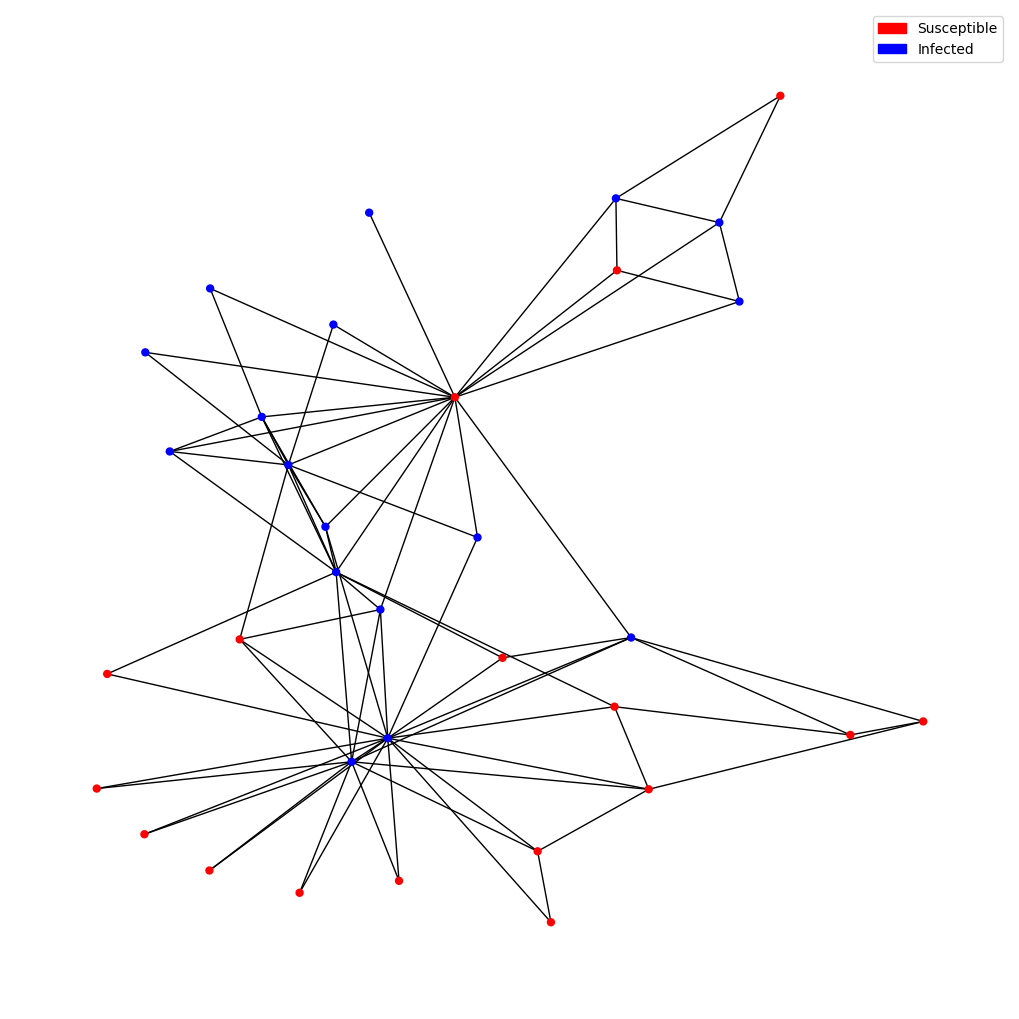

In [29]:
# Visualize graph
graph_layout_sis_karate_club = visualize.plot_graph(sis_model_karate_club_pred_states,
                                                    graph_karate_club,
                                                    classes=['Susceptible', 'Infected'])

##### **Explanation**

The time series below depicts infections spiking, then lowering, then entering an unstable "equilibrium". Since the infection and recovery rates are so high - and since the network is so interconnected - the states alternate infinitely around the point as depicted as the virus moves throughout the nodes and as the nodes recover.

Despite this being a SIS model, there is not a point where the virus dissipates since it is near equilibrium. As there is no immunity, such dynamics will continue indefinitely.

<Figure size 1000x500 with 0 Axes>

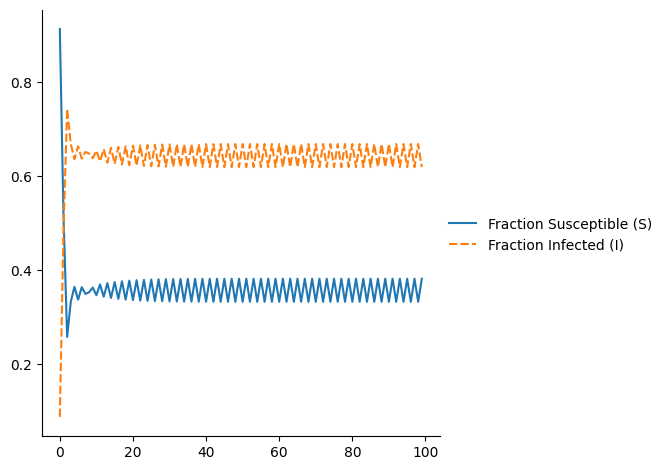

In [30]:
# Visualize time-series
series_sis_karate_club = epilearn.visualize.plot_series(SIS_preds_to_time_series(sis_model_karate_club_preds), # Convert preds from tensor to time-series numpy array
                                                        ['Fraction Susceptible (S)', 'Fraction Infected (I)'],
                                                        fig_size=(10, 5))

## NetSIS Facebook Connections

In [31]:
# Convert data to NumPy format
sis_model_facebook_pred_states = sis_model_facebook_preds.argmax(2)[EXTRACTED_STEP].detach().numpy() # states at slice t
graph_facebook = adj_facebook.to_sparse().indices().detach().numpy()

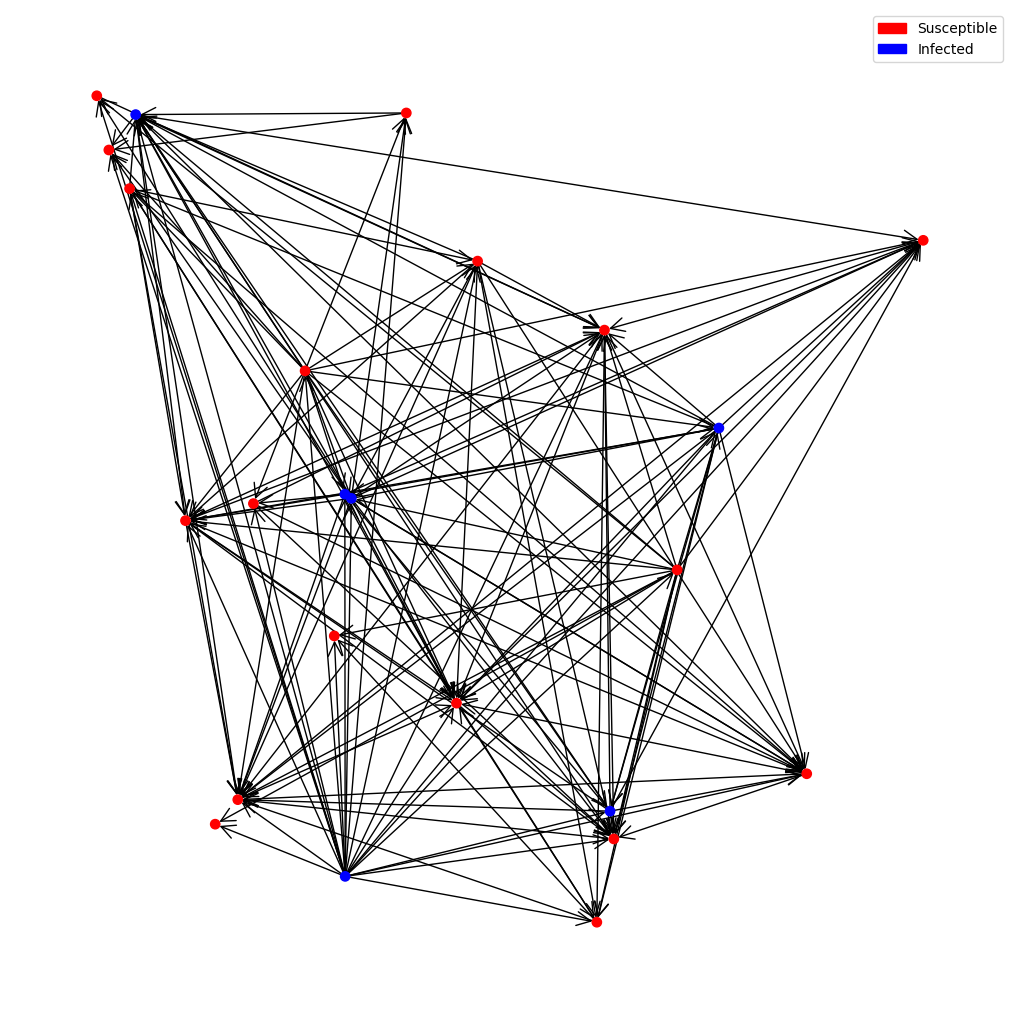

In [32]:
# Visualize graph
graph_layout_sis_facebook = plot_directed_graph(sis_model_facebook_pred_states,
                                                graph_facebook,
                                                classes=['Susceptible', 'Infected'])

##### **Explanation**

The time series below depicts infections spiking, then steadily lowering before the virus is wiped out. Despite an identical set of infection and recovery rates as above (as somewhat indicated by the choppiness of the compartments), the directed nature of the graph - alongside the slightly less connected network - contributes to the virus being overcome by the network's inability to transmit it.

<Figure size 1000x500 with 0 Axes>

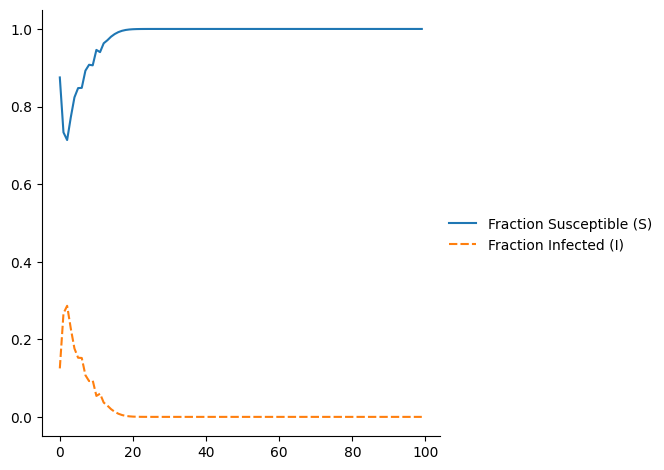

In [33]:
# Visualize time-series
series_sis_facebook = epilearn.visualize.plot_series(SIS_preds_to_time_series(sis_model_facebook_preds), # Convert preds from tensor to time-series numpy array
                                                    ['Fraction Susceptible (S)', 'Fraction Infected (I)'],
                                                    fig_size=(10, 5))

## NetSEIRS Karate Club

In [34]:
# Convert data to NumPy format
seirs_model_karate_club_pred_states = seirs_model_karate_club_preds.argmax(2)[EXTRACTED_STEP].detach().numpy() # states at slice t
graph_karate_club = adj_karate_club.to_sparse().indices().detach().numpy()

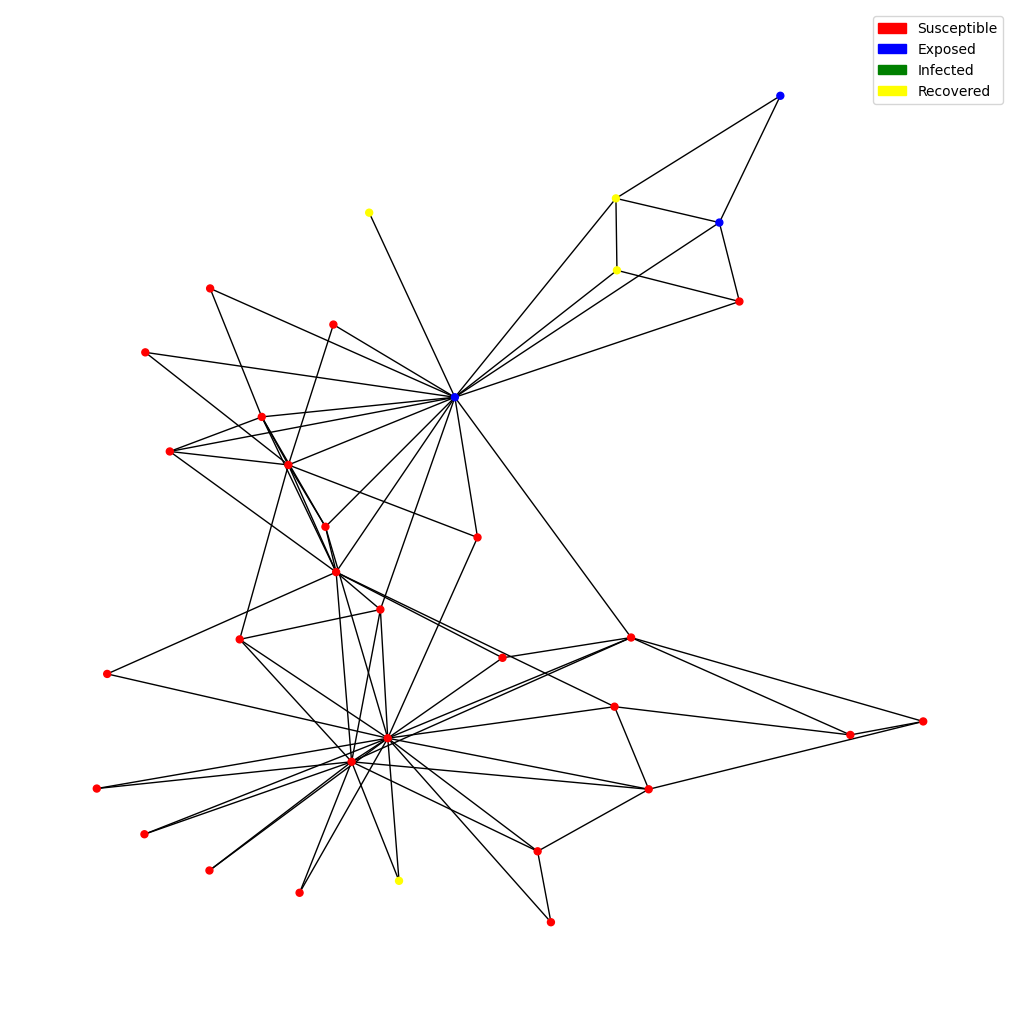

In [35]:
# Visualize graph
graph_layout_seirs_karate_club = visualize.plot_graph(seirs_model_karate_club_pred_states,
                                                      graph_karate_club,
                                                      classes=['Susceptible', 'Exposed', 'Infected', 'Recovered'])

##### **Explanation**

The time series below depicts susceptible rapidly dropping as people are exposed. Shortly after, infections rise. At the same time, recoveries rise as the initial infected begin to recover. These values stabilize as they reach equilibrium / steady state where there is no net change in state ratios given they do not change.

<Figure size 1000x500 with 0 Axes>

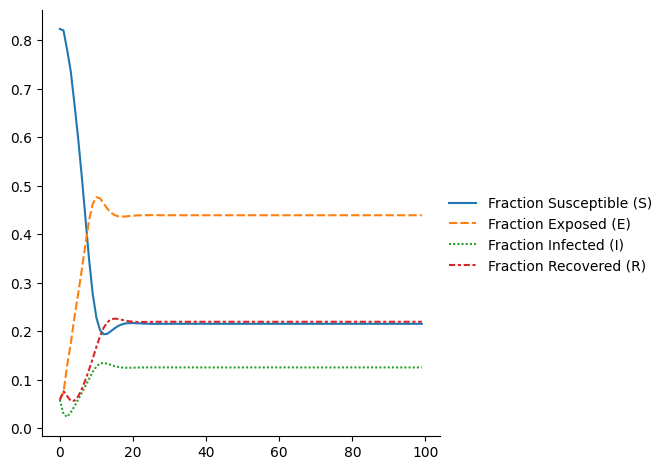

In [36]:
# Visualize time-series
series_seirs_karate_club = epilearn.visualize.plot_series(SEIRS_preds_to_time_series(seirs_model_karate_club_preds), # Convert preds from tensor to time-series numpy array
                                                    ['Fraction Susceptible (S)', 'Fraction Exposed (E)', 'Fraction Infected (I)', 'Fraction Recovered (R)'],
                                                    fig_size=(10, 5))

## NetSEIRS Facebook Connections

In [37]:
# Convert data to NumPy format
seirs_model_facebook_pred_states = seirs_model_facebook_preds.argmax(2)[EXTRACTED_STEP].detach().numpy() # states at slice t
graph_facebook = adj_facebook.to_sparse().indices().detach().numpy()

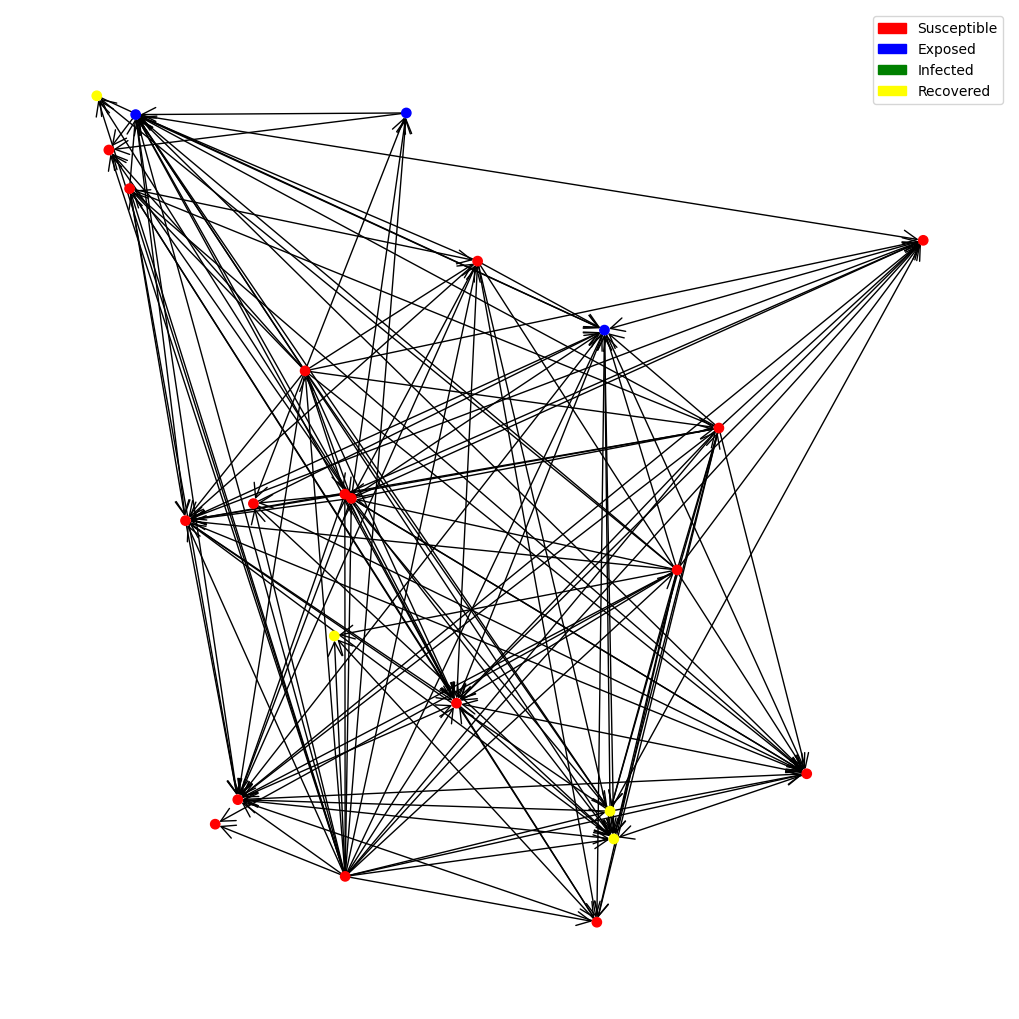

In [38]:
# Visualize graph
graph_layout_seirs_facebook = plot_directed_graph(seirs_model_facebook_pred_states,
                                                  graph_facebook,
                                                  classes=['Susceptible', 'Exposed', 'Infected', 'Recovered'])

##### **Explanation**

The time series below depicts susceptible dropping as exposures likewise rise. Given the nature of the directed network, the disease's momentum is stalled quickly, as seen by the infections dropping immediately from `initial_state` alongside everything else while susceptible begins to rise once again until the virus is gone.

<Figure size 1000x500 with 0 Axes>

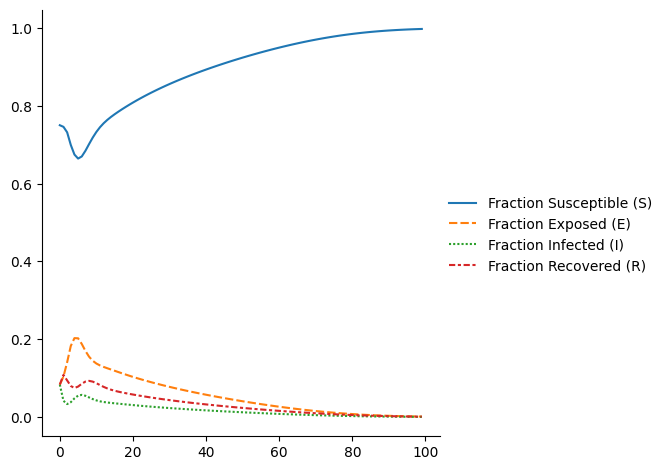

In [39]:
# Visualize time-series
series_seirs_facebook = epilearn.visualize.plot_series(SEIRS_preds_to_time_series(seirs_model_facebook_preds), # Convert preds from tensor to time-series numpy array
                                                    ['Fraction Susceptible (S)', 'Fraction Exposed (E)', 'Fraction Infected (I)', 'Fraction Recovered (R)'],
                                                    fig_size=(10, 5))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d0b016ea-7052-481c-b384-8d9a601de0d7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>